<a href="https://colab.research.google.com/github/dimi-fn/Emotion-Recognition-in-Movie-Abstracts/blob/master/4d_Model_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries for data analysis and manipulation
import pandas as pd
import numpy as np

np.random.seed(42) # to make this notebook's output stable across runs

# For plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Generating the version of a wide variety of packages/libraries used & working environment
#pd.__version__
#pd.show_versions(as_json=False)


In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# `movies_final_3`

In [ ]:
downloaded = drive.CreateFile({'id':'1Xys1Ve5DHr3gI10lhdM_k2xN3uDT0c6k'}) 
downloaded.GetContentFile('movies_final_3.csv') 

movies_final_3 = pd.read_csv('movies_final_3.csv') 
movies_final_3.shape

(55877, 17)

In [ ]:
# nulls are only the unlabelled emotions

movies_final_3.isnull().sum()

movieId                      0
tmdbId                       0
title                        0
genres                       0
overview                     0
Vader_score                  0
Vader_compound               0
Vader_polarity               0
NMF_topic                    0
NMF_topic_description        0
entities                     0
happiness                55577
sadness                  55577
anger                    55577
disgust                  55577
fear                     55577
surprise                 55577
dtype: int64

In [ ]:
movies_final_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55877 entries, 0 to 55876
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                55877 non-null  int64  
 1   tmdbId                 55877 non-null  float64
 2   title                  55877 non-null  object 
 3   genres                 55877 non-null  object 
 4   overview               55877 non-null  object 
 5   Vader_score            55877 non-null  object 
 6   Vader_compound         55877 non-null  float64
 7   Vader_polarity         55877 non-null  object 
 8   NMF_topic              55877 non-null  int64  
 9   NMF_topic_description  55877 non-null  object 
 10  entities               55877 non-null  object 
 11  happiness              300 non-null    float64
 12  sadness                300 non-null    float64
 13  anger                  300 non-null    float64
 14  disgust                300 non-null    float64
 15  fe

## Fixing attribute "Vader_score"

In [ ]:
# fixing "Vader_score" attribute in the same way it was fixed in the previous notebooks


# converting the Vader_score attribute into an object type
movies_final_3["Vader_score"] = movies_final_3["Vader_score"].astype("object")

In [ ]:
from pandas.api.types import is_dict_like
is_dict_like(movies_final_3.Vader_score)

True

In [ ]:
movies_final_3["Vader_score"] = movies_final_3["Vader_score"].apply(lambda x: dict(eval(x)))

In [ ]:
df_temp= movies_final_3["Vader_score"].apply(pd.Series)
df_temp[:3]

,neg,neu,pos,compound
0,0.048,0.886,0.066,0.2500
1,0.161,0.702,0.137,-0.4588
2,0.168,0.791,0.041,-0.7645


In [ ]:
result= pd.concat([df_temp, movies_final_3], axis=1).drop(["Vader_score", "Vader_compound"], axis=1)
result.shape
# 2 new columns added (2 columns removed, 4 were added)
# "Vader_score" is not needed anymore since its values are now displayed as new columns
# "Vader_compound" is replaced by the compound score inside the compound key values provided by the Vader_score
# Hence, we now have: "compound" (old "Vader_compound") | "neg"| "neu"| "pos"
# (55877, 19)

(55877, 19)

In [ ]:
movies_final_3=result
movies_final_3.shape

(55877, 19)

In [ ]:
# changing the order of columns

movies_final_3 =  movies_final_3[["movieId","tmdbId","title","genres","overview","Vader_polarity","compound","neg","neu","pos","NMF_topic","NMF_topic_description","entities","happiness","sadness","anger","disgust","fear","surprise"]]
movies_final_3.shape

(55877, 19)

In [ ]:
movies_final_3.head(3)

,movieId,tmdbId,title,genres,overview,Vader_polarity,compound,neg,neu,pos,NMF_topic,NMF_topic_description,entities,happiness,sadness,anger,disgust,fear,surprise
0,1,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ...",positive,0.2500,0.048,0.886,0.066,0,Battle|Offence,PERSON|PERSON|PERSON|PERSON|PERSON|PERSON|ORG|...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,8844.0,Jumanji (1995),Adventure|Children|Fantasy,When siblings Judy and Peter discover an encha...,negative,-0.4588,0.161,0.702,0.137,5,War|Crime,PERSON|PERSON|ORG|PERSON|DATE|PERSON|CARDINAL,NaN,NaN,NaN,NaN,NaN,NaN
2,3,15602.0,Grumpier Old Men (1995),Comedy|Romance,A family wedding reignites the ancient feud be...,negative,-0.7645,0.168,0.791,0.041,6,Family|Relatives,PERSON|PERSON|NORP|PERSON,NaN,NaN,NaN,NaN,NaN,NaN


## Dtype conversions of other attributes

In [ ]:
# converting the below categorical attributes into type "category"
# they will then be label encoded and one_hot_encoded when and if necessary
movies_final_3["title"] = movies_final_3["title"].astype("category")

movies_final_3["genres"] = movies_final_3["genres"].astype("category")

movies_final_3["Vader_polarity"] = movies_final_3["Vader_polarity"].astype("category")

movies_final_3["NMF_topic_description"] = movies_final_3["NMF_topic_description"].astype("category")

movies_final_3["entities"] = movies_final_3["entities"].astype("category")

In [ ]:
movies_final_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55877 entries, 0 to 55876
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   movieId                55877 non-null  int64   
 1   tmdbId                 55877 non-null  float64 
 2   title                  55877 non-null  category
 3   genres                 55877 non-null  category
 4   overview               55877 non-null  object  
 5   Vader_polarity         55877 non-null  category
 6   compound               55877 non-null  float64 
 7   neg                    55877 non-null  float64 
 8   neu                    55877 non-null  float64 
 9   pos                    55877 non-null  float64 
 10  NMF_topic              55877 non-null  int64   
 11  NMF_topic_description  55877 non-null  category
 12  entities               55877 non-null  category
 13  happiness              300 non-null    float64 
 14  sadness                300 non-null   

In [ ]:
movies_final_3.head(1)

,movieId,tmdbId,title,genres,overview,Vader_polarity,compound,neg,neu,pos,NMF_topic,NMF_topic_description,entities,happiness,sadness,anger,disgust,fear,surprise
0,1,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Led by Woody, Andy's toys live happily in his ...",positive,0.25,0.048,0.886,0.066,0,Battle|Offence,PERSON|PERSON|PERSON|PERSON|PERSON|PERSON|ORG|...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# final shape of all dataset (labelled & unlabelled)
movies_final_3.shape

(55877, 19)

## Splitting the data between labelled and unlabelled regarding emotion's labelling

### labelled_df

In [ ]:
# labelled dataframe
# 300 emotions to 300 movie overviews
# it should include 300 rows

data=[]
for row in movies_final_3.itertuples(index=True, name='Pandas'):
  if (row.happiness ==0 or row.happiness==1) or (row.sadness ==0 or row.sadness==1) or (row.anger==0 or row.anger==1) or (row.disgust==0 or row.disgust==1) or (row.fear==0 or row.fear==1) or (row.surprise==0 and row.surprise==1):
    data.append([row.movieId, row.tmdbId, row.title, row.genres, row.overview,
                 row.Vader_polarity, row.compound, row.neg, row.neu, row.pos,
                 row.NMF_topic, row.NMF_topic_description, row.entities, 
                 row.happiness, row.sadness, row.anger, row.disgust, row.fear, row.surprise])

labelled_df = pd.DataFrame(data, columns=['movieId', 'tmdbId', "title", 'genres', "overview",
                                          "Vader_polarity", "compound", "neg", "neu", "pos",
                                          "NMF_topic", "NMF_topic_description", "entities", 
                                          "happiness", "sadness", "anger", "disgust", "fear", "surprise"
                                          ])
labelled_df.shape

(300, 19)

In [ ]:
labelled_df.isnull().sum().any()

False

In [ ]:
labelled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                300 non-null    int64  
 1   tmdbId                 300 non-null    float64
 2   title                  300 non-null    object 
 3   genres                 300 non-null    object 
 4   overview               300 non-null    object 
 5   Vader_polarity         300 non-null    object 
 6   compound               300 non-null    float64
 7   neg                    300 non-null    float64
 8   neu                    300 non-null    float64
 9   pos                    300 non-null    float64
 10  NMF_topic              300 non-null    int64  
 11  NMF_topic_description  300 non-null    object 
 12  entities               300 non-null    object 
 13  happiness              300 non-null    float64
 14  sadness                300 non-null    float64
 15  anger 

##### `labelled_df.csv`

In [ ]:
'''
from google.colab import files

labelled_df.to_csv('labelled_df.csv', index=False)
files.download('labelled_df.csv')

labelled_df.to_csv('labelled_df_index.csv', index=True)
files.download('labelled_df_index.csv')
'''

"\nfrom google.colab import files\n\nlabelled_df.to_csv('labelled_df.csv', index=False)\nfiles.download('labelled_df.csv')\n\nlabelled_df.to_csv('labelled_df_index.csv', index=True)\nfiles.download('labelled_df_index.csv')\n"

##### Split: train-valid-test

In [ ]:
emotions = ["happiness", "sadness", "anger", "disgust", "fear", "surprise"]

from sklearn.model_selection import train_test_split


x_train_val, x_test, y_train_val, y_test= train_test_split(labelled_df[["title", "genres", "overview", "Vader_polarity", "compound", "neg", "neu", "pos", "NMF_topic", "NMF_topic_description", "entities"]] , labelled_df[["happiness", "sadness", "anger", "disgust", "fear", "surprise"]], test_size=0.1, random_state=42)

In [ ]:
labelled_df.head(2)

,movieId,tmdbId,title,genres,overview,Vader_polarity,compound,neg,neu,pos,NMF_topic,NMF_topic_description,entities,happiness,sadness,anger,disgust,fear,surprise
0,5,11862.0,Father of the Bride Part II (1995),Comedy,Just when George Banks has recovered from his ...,positive,0.5023,0.000,0.944,0.056,0,Battle|Offence,PERSON|PERSON|PERSON|PERSON,1.0,0.0,0.0,0.0,0.0,1.0
1,9,9091.0,Sudden Death (1995),Action,When a man's daughter is suddenly taken during...,positive,0.4404,0.099,0.759,0.143,1,Affairs|Mystery,MONEY,0.0,1.0,1.0,0.0,1.0,0.0


### unlabelled_df

In [ ]:
# unlabelled dataframe
# it should include initial number of rows - 300 = 55877 - 300 = 55,577 rows

data=[]
for row in movies_final_3.itertuples(index=True, name='Pandas'):
  if not((row.happiness ==0 or row.happiness==1) or (row.sadness ==0 or row.sadness==1) or (row.anger==0 or row.anger==1) or (row.disgust==0 or row.disgust==1) or (row.fear==0 or row.fear==1) or (row.surprise==0 and row.surprise==1)):
    data.append([row.movieId, row.tmdbId, row.title, row.genres, row.overview,
                 row.Vader_polarity, row.compound, row.neg, row.neu, row.pos,
                 row.NMF_topic, row.NMF_topic_description, row.entities, 
                 row.happiness, row.sadness, row.anger, row.disgust, row.fear, row.surprise])

unlabelled_df = pd.DataFrame(data, columns=['movieId', 'tmdbId', "title", 'genres', "overview",
                                          "Vader_polarity", "compound", "neg", "neu", "pos",
                                          "NMF_topic", "NMF_topic_description", "entities", 
                                          "happiness", "sadness", "anger", "disgust", "fear", "surprise"
                                          ])
unlabelled_df.shape

(55577, 19)

In [ ]:
# null are the unlabelled emotions
unlabelled_df.isnull().sum()

movieId                      0
tmdbId                       0
title                        0
genres                       0
overview                     0
Vader_polarity               0
compound                     0
neg                          0
neu                          0
pos                          0
NMF_topic                    0
NMF_topic_description        0
entities                     0
happiness                55577
sadness                  55577
anger                    55577
disgust                  55577
fear                     55577
surprise                 55577
dtype: int64

In [ ]:
unlabelled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55577 entries, 0 to 55576
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                55577 non-null  int64  
 1   tmdbId                 55577 non-null  float64
 2   title                  55577 non-null  object 
 3   genres                 55577 non-null  object 
 4   overview               55577 non-null  object 
 5   Vader_polarity         55577 non-null  object 
 6   compound               55577 non-null  float64
 7   neg                    55577 non-null  float64
 8   neu                    55577 non-null  float64
 9   pos                    55577 non-null  float64
 10  NMF_topic              55577 non-null  int64  
 11  NMF_topic_description  55577 non-null  object 
 12  entities               55577 non-null  object 
 13  happiness              0 non-null      float64
 14  sadness                0 non-null      float64
 15  an

#### `unlabelled_df.csv`

In [ ]:
'''
unlabelled_df.to_csv('unlabelled_df.csv', index=False)
files.download('unlabelled_df.csv')

unlabelled_df.to_csv('unlabelled_df_index.csv', index=True)
files.download('unlabelled_df_index.csv')
'''

"\nunlabelled_df.to_csv('unlabelled_df.csv', index=False)\nfiles.download('unlabelled_df.csv')\n\nunlabelled_df.to_csv('unlabelled_df_index.csv', index=True)\nfiles.download('unlabelled_df_index.csv')\n"

# labelled_df

In [ ]:
# without index
downloaded = drive.CreateFile({'id':'1ITV4Mlac37ecNQFtcVRvVV99BC-Gu9jQ'}) 
downloaded.GetContentFile('labelled_df.csv') 

labelled_df = pd.read_csv('labelled_df.csv') 
print("Shape of 'labelled_df' (without index) is: {}".format(labelled_df.shape))

# with index
downloaded = drive.CreateFile({'id':'1plFy00oCE_sxNQLZq_tGZS5f4VlTD32I'}) 
downloaded.GetContentFile('labelled_df_index.csv') 

labelled_df_index = pd.read_csv('labelled_df_index.csv') 
print("Shape of 'labelled_df_index' (with index) is: {}".format(labelled_df_index.shape))

Shape of 'labelled_df' (without index) is: (300, 19)
Shape of 'labelled_df_index' (with index) is: (300, 20)


In [ ]:
labelled_df.isnull().sum().any()

False

In [ ]:
# convert emotions into int type since fast-bert requires binary inputs, i.e 0 or 1

labelled_df["happiness"] = labelled_df["happiness"].astype(int)

labelled_df["sadness"] = labelled_df["sadness"].astype(int)

labelled_df["anger"] = labelled_df["anger"].astype(int)

labelled_df["disgust"] = labelled_df["disgust"].astype(int)

labelled_df["fear"] = labelled_df["fear"].astype(int)

labelled_df["surprise"] = labelled_df["surprise"].astype(int)

labelled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                300 non-null    int64  
 1   tmdbId                 300 non-null    float64
 2   title                  300 non-null    object 
 3   genres                 300 non-null    object 
 4   overview               300 non-null    object 
 5   Vader_polarity         300 non-null    object 
 6   compound               300 non-null    float64
 7   neg                    300 non-null    float64
 8   neu                    300 non-null    float64
 9   pos                    300 non-null    float64
 10  NMF_topic              300 non-null    int64  
 11  NMF_topic_description  300 non-null    object 
 12  entities               300 non-null    object 
 13  happiness              300 non-null    int64  
 14  sadness                300 non-null    int64  
 15  anger 

## train & val csv files for bert


In [ ]:
labelled_df.shape

(300, 19)

In [ ]:
train= labelled_df[:240]
val= labelled_df[240:270]
test= labelled_df[270:]

In [ ]:
train = train[["movieId", "overview", "happiness", "sadness", "anger", "disgust", "fear", "surprise"]]
val= val[["movieId", "overview", "happiness", "sadness", "anger", "disgust", "fear", "surprise"]]
test= test[["movieId", "overview", "happiness", "sadness", "anger", "disgust", "fear", "surprise"]]
labels=["happiness", "sadness", "anger", "disgust", "fear", "surprise"]
print(train.shape)
print(val.shape)
print(test.shape)

(240, 8)
(30, 8)
(30, 8)


In [ ]:
'''
from google.colab import files

train.to_csv('train.csv', index=False)
files.download('train.csv')

val.to_csv('val.csv', index=False)
files.download('val.csv')

test.to_csv('test.csv', index=False)
files.download('test.csv')
'''

"\n\nfrom google.colab import files\n\ntrain.to_csv('train.csv', index=False)\nfiles.download('train.csv')\n\nval.to_csv('val.csv', index=False)\nfiles.download('val.csv')\n\ntest.to_csv('test.csv', index=False)\nfiles.download('test.csv')\n\n\n"

# unlabelled_df

In [ ]:
# without index
downloaded = drive.CreateFile({'id':'1O7pB2iVaILetUG1uHWmqOG3OUOUjzMKf'}) 
downloaded.GetContentFile('unlabelled_df.csv') 

unlabelled_df = pd.read_csv('unlabelled_df.csv') 
print("Shape of 'unlabelled_df' (with index) is: {}".format(unlabelled_df.shape))

# with index
downloaded = drive.CreateFile({'id':'1JVQtiSsx4Yqazkyh2-iZXXyIiTpGeCJ8'}) 
downloaded.GetContentFile('unlabelled_df_index.csv') 

unlabelled_df_index = pd.read_csv('unlabelled_df_index.csv') 
print("Shape of 'unlabelled_df_index' (with index) is: {}".format(unlabelled_df_index.shape))

Shape of 'unlabelled_df' (with index) is: (55577, 19)
Shape of 'unlabelled_df_index' (with index) is: (55577, 20)


In [ ]:
unlabelled_df.isnull().sum()

movieId                      0
tmdbId                       0
title                        0
genres                       0
overview                     0
Vader_polarity               0
compound                     0
neg                          0
neu                          0
pos                          0
NMF_topic                    0
NMF_topic_description        0
entities                     0
happiness                55577
sadness                  55577
anger                    55577
disgust                  55577
fear                     55577
surprise                 55577
dtype: int64

# Drive Environment set up

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

'Back up'  'Colab Notebooks'  'Copy of kaggle.json'


In [ ]:
# data path
!ls "/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/data_dir"

cache  test.csv  train.csv  val.csv


In [ ]:
# labels path

!ls "/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/labels"

labels.csv


# References

[fast-bert](https://github.com/kaushaltrivedi/fast-bert)

[Kaushal Trivedi
](https://medium.com/huggingface/introducing-fastbert-a-simple-deep-learning-library-for-bert-models-89ff763ad384)


# fast-BERT

In [ ]:
pip install fast-bert

     |████████████████████████████████| 92kB 4.2MB/s 
     |████████████████████████████████| 3.0MB 16.9MB/s 
     |████████████████████████████████| 317kB 56.1MB/s 
     |████████████████████████████████| 778kB 23.2MB/s 
     |████████████████████████████████| 890kB 49.1MB/s 
     |████████████████████████████████| 1.1MB 45.9MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=e710420bb197dc9d19da76eb8ac4c8c4f232131cbb28b30dbf34db266cbb98c4
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8aedfdf5f94981191c13c41b55890e7baa5eb655ac222427e3f1a028386ea0fe
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built seqeval sacremoses


In [ ]:
'''
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex
'''

'\n%%writefile setup.sh\n\ngit clone https://github.com/NVIDIA/apex\npip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex\n'

In [ ]:
#!sh setup.sh

In [ ]:
#!pip install apexpy

In [ ]:
#import apex

In [ ]:
import torch

In [ ]:
!nvidia-smi

Sun Aug  2 01:51:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
try:
  import apex
except Exception:
  ! git clone https://github.com/NVIDIA/apex.git
  % cd apex
  !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
  %cd ..

Cloning into 'apex'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 7401 (delta 0), reused 0 (delta 0), pack-reused 7400
Receiving objects: 100% (7401/7401), 13.89 MiB | 18.52 MiB/s, done.
Resolving deltas: 100% (5000/5000), done.
/content/apex
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Processing /content/apex
Skipping wheel build for apex, due to binaries being disabled for it.
    Running setup.py install for apex ... done
/content


In [ ]:
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging

logger = logging.getLogger()
device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]

In [ ]:
labels= ["happiness", "sadness", "anger", "disgust", "fear", "surprise"]

In [ ]:
from fast_bert.data_cls import BertDataBunch

DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/data_dir"

LABEL_PATH = "/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/labels"


databunch = BertDataBunch(DATA_PATH, LABEL_PATH,
                          tokenizer='bert-base-uncased',
                          train_file='train.csv',
                          val_file='val.csv',
                          label_file='labels.csv',
                          text_col='overview',
                          label_col= labels,
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=True,
                          multi_label=True,
                          model_type='bert')

In [ ]:
OUTPUT_DIR = "/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/output_directory"

In [ ]:
learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir=OUTPUT_DIR,
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=True,
						is_fp16=True,
						multi_label=True,
						logging_steps=50)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not 

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/apex/amp/wrap.py:101: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return orig_fn(arg0, *args, **kwargs)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 128.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 64.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16.0
Gradient overflow.  Skipping step, loss scaler 0 reducing l

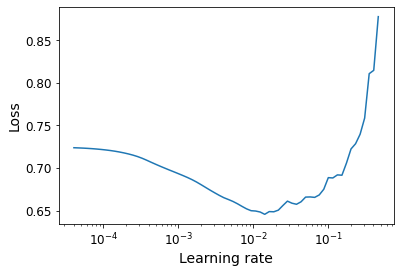

In [ ]:
learner.lr_find(start_lr=1e-5,optimizer_type='lamb')

In [ ]:
learner.fit(epochs=6,
			lr=6e-5,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="lamb")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(90, 0.7215312010712094)

In [ ]:
learner.save_model()

In [ ]:
# 1st movie overview of the labelled_df
text= labelled_df["overview"][1]
from IPython.display import Markdown, display
display(Markdown('> '+text))

> When a man's daughter is suddenly taken during a championship hockey game – with the captors demanding a billion dollars by game's end – he frantically sets a plan in motion to rescue her and abort an impending explosion before the final buzzer.

In [ ]:
text = ["When a man's daughter is suddenly taken during a championship hockey game – with the captors demanding a billion dollars by game's end – he frantically sets a plan in motion to rescue her and abort an impending explosion before the final buzzer."]
predictions = learner.predict_batch(text)
predictions

[[('disgust', 0.6474609375),
  ('anger', 0.58935546875),
  ('happiness', 0.525390625),
  ('fear', 0.489501953125),
  ('sadness', 0.427490234375),
  ('surprise', 0.38720703125)]]

In [ ]:
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
import apex
from sklearn.model_selection import train_test_split

import datetime

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc

In [ ]:

torch.cuda.empty_cache()

In [ ]:
pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/data_dir"

LABEL_PATH = "/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/labels"



AUG_DATA_PATH = Path('../data/data_augmentation/')

MODEL_PATH=Path('../models/')
LOG_PATH=Path('../logs/')
MODEL_PATH.mkdir(exist_ok=True)

model_state_dict = None

# BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/cased_L-12_H-768_A-12/')
BERT_PRETRAINED_PATH = Path('../../bert_models/pretrained-weights/uncased_L-12_H-768_A-12/')
# BERT_PRETRAINED_PATH = Path('../../bert_fastai/pretrained-weights/uncased_L-24_H-1024_A-16/')
# FINETUNED_PATH = Path('../models/finetuned_model.bin')
FINETUNED_PATH = None
# model_state_dict = torch.load(FINETUNED_PATH)

LOG_PATH.mkdir(exist_ok=True)

OUTPUT_PATH = MODEL_PATH/'output'
OUTPUT_PATH.mkdir(exist_ok=True)

In [ ]:

args = Box({
    "run_text": "multilabel classification of emotions",
    "train_size": -1,
    "val_size": -1,
    "log_path": LOG_PATH,
    "full_data_dir": DATA_PATH,
    "data_dir": DATA_PATH,
    "task_name": "emotion_classification_and_prediction",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": OUTPUT_PATH,
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 8,
    "eval_batch_size": 16,
    "learning_rate": 5e-5,
    "num_train_epochs": 6,
    "warmup_proportion": 0.0,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": True,
    "fp16_opt_level": "O1",
    "weight_decay": 0.0,
    "adam_epsilon": 1e-8,
    "max_grad_norm": 1.0,
    "max_steps": -1,
    "warmup_steps": 500,
    "logging_steps": 50,
    "eval_all_checkpoints": True,
    "overwrite_output_dir": True,
    "overwrite_cache": False,
    "seed": 42,
    "loss_scale": 128,
    "task_name": 'intent',
    "model_name": 'xlnet-base-cased',
    "model_type": 'xlnet'
})

In [ ]:
import logging

logfile = str(LOG_PATH/'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
    datefmt='%m/%d/%Y %H:%M:%S',
    handlers=[
        logging.FileHandler(logfile),
        logging.StreamHandler(sys.stdout)
    ])

logger = logging.getLogger()

In [ ]:
logger.info(args)

08/02/2020 02:19:09 - INFO - root -   {'run_text': 'multilabel classification of emotions', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('../logs'), 'full_data_dir': '/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/data_dir', 'data_dir': '/content/drive/My Drive/Colab Notebooks/Thesis/MovieLens/datasets/my_csvs/bert/data_dir', 'task_name': 'intent', 'no_cuda': False, 'bert_model': PosixPath('../../bert_models/pretrained-weights/uncased_L-12_H-768_A-12'), 'output_dir': PosixPath('../models/output'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 6, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': True, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, '

In [ ]:
#tokenizer = BertTokenizer.from_pretrained(BERT_PRETRAINED_PATH, do_lower_case=args['do_lower_case'])

In [ ]:
device = torch.device('cuda')
if torch.cuda.device_count() > 1:
    args.multi_gpu = True
else:
    args.multi_gpu = False

In [ ]:
databunch = BertDataBunch(args['data_dir'], LABEL_PATH, args.model_name, train_file='train.csv', val_file='val.csv',
                          test_data='test.csv',
                          text_col="overview", label_col=labels,
                          batch_size_per_gpu=args['train_batch_size'], max_seq_length=args['max_seq_length'], 
                          multi_gpu=args.multi_gpu, multi_label=True, model_type=args.model_type)

08/02/2020 02:20:19 - INFO - filelock -   Lock 140690739325304 acquired on /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6.lock
08/02/2020 02:20:19 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmppbtuuwdf



08/02/2020 02:20:19 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json in cache at /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6
08/02/2020 02:20:19 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6
08/02/2020 02:20:19 - INFO - filelock -   Lock 140690739325304 released on /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6.lock
08/02/2020 02:20:19 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /ro


08/02/2020 02:20:20 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model in cache at /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8
08/02/2020 02:20:20 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8
08/02/2020 02:20:20 - INFO - filelock -   Lock 140690742153680 released on /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8.lock
08/02/2020 02:20:20 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model from cache at /root/.cach

In [ ]:
databunch.labels

['happiness', 'sadness', 'anger', 'disgust', 'fear', 'surprise']

In [ ]:
metrics = []
metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
metrics.append({'name': 'roc_auc', 'function': roc_auc})
metrics.append({'name': 'fbeta', 'function': fbeta})

In [ ]:
learner = BertLearner.from_pretrained_model(databunch, args.model_name, metrics=metrics, 
                                            device=device, logger=logger, output_dir=args.output_dir, 
                                            finetuned_wgts_path=FINETUNED_PATH, warmup_steps=args.warmup_steps,
                                            multi_gpu=args.multi_gpu, is_fp16=args.fp16, 
                                            multi_label=True, logging_steps=0)

08/02/2020 02:21:35 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6
08/02/2020 02:21:35 - INFO - transformers.configuration_utils -   Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 


08/02/2020 02:21:53 - INFO - transformers.file_utils -   storing https://cdn.huggingface.co/xlnet-base-cased-pytorch_model.bin in cache at /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac
08/02/2020 02:21:53 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac
08/02/2020 02:21:53 - INFO - filelock -   Lock 140690743666336 released on /root/.cache/torch/transformers/33d6135fea0154c088449506a4c5f9553cb59b6fd040138417a7033af64bb8f9.7eac4fe898a021204e63c88c00ea68c60443c57f94b4bc3c02adbde6465745ac.lock
08/02/2020 02:21:53 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/xlnet-base-cased-pytorch_model.bin from cache at /root/.cache/torch/transformers/33d6135fea0154c08844

In [ ]:
learner.fit(args.num_train_epochs, args.learning_rate, validate=True)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
08/02/2020 02:22:42 - INFO - root -   ***** Running training *****
08/02/2020 02:22:42 - INFO - root -     Num examples = 240
08/02/2020 02:22:42 - INFO - root -     Num Epochs = 6
08/02/2020 02:22:42 - INFO - root -     Total train batch size (w. parallel, distributed & accumulation) = 8
08/02/2020 02:22:42 - I

/usr/local/lib/python3.6/dist-packages/apex/amp/wrap.py:53: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  return orig_fn(*args, **kwargs)


08/02/2020 02:23:32 - INFO - root -   Running evaluation
08/02/2020 02:23:32 - INFO - root -     Num examples = 30
08/02/2020 02:23:32 - INFO - root -     Batch size = 16


08/02/2020 02:23:36 - INFO - root -   eval_loss after epoch 1: 0.6707426905632019: 
08/02/2020 02:23:36 - INFO - root -   eval_accuracy_thresh after epoch 1: 0.5777778029441833: 
08/02/2020 02:23:36 - INFO - root -   eval_roc_auc after epoch 1: 0.5792004048582996: 
08/02/2020 02:23:36 - INFO - root -   eval_fbeta after epoch 1: 0.7561327815055847: 
08/02/2020 02:23:36 - INFO - root -   lr after epoch 1: 3e-06
08/02/2020 02:23:36 - INFO - root -   train_loss after epoch 1: 0.6993247111638387
08/02/2020 02:23:36 - INFO - root -   



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


08/02/2020 02:24:27 - INFO - root -   Running evaluation
08/02/2020 02:24:27 - INFO - root -     Num examples = 30
08/02/2020 02:24:27 - INFO - root -     Batch size = 16


08/02/2020 02:24:31 - INFO - root -   eval_loss after epoch 2: 0.6650340259075165: 
08/02/2020 02:24:31 - INFO - root -   eval_accuracy_thresh after epoch 2: 0.5888888835906982: 
08/02/2020 02:24:31 - INFO - root -   eval_roc_auc after epoch 2: 0.5980516194331983: 
08/02/2020 02:24:31 - INFO - root -   eval_fbeta after epoch 2: 0.7561327815055847: 
08/02/2020 02:24:31 - INFO - root -   lr after epoch 2: 6e-06
08/02/2020 02:24:31 - INFO - root -   train_loss after epoch 2: 0.6933609028657277
08/02/2020 02:24:31 - INFO - root -   

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
08/02/2020 02:25:22 - INFO - root -   Running evaluation
08/02/2020 02:25:22 - INFO - root -     Num examples = 30
08/02/2020 02:25:22 - INFO - root -     Batch size = 16


08/02/2020 02:25:25 - INFO - root -   eval_loss after epoch 3: 0.6580394804477692: 
08/02/2020 02:25:25 - INFO - root -   eval_accuracy_thresh after epoch 3: 0.6166666746139526: 
08/02/2020 02:25:25 - INFO - root -   eval_roc_auc after epoch 3: 0.6262019230769231: 
08/02/2020 02:25:25 - INFO - root -   eval_fbeta after epoch 3: 0.7561327815055847: 
08/02/2020 02:25:25 - INFO - root -   lr after epoch 3: 9e-06
08/02/2020 02:25:25 - INFO - root -   train_loss after epoch 3: 0.692991562684377
08/02/2020 02:25:25 - INFO - root -   

08/02/2020 02:26:16 - INFO - root -   Running evaluation
08/02/2020 02:26:16 - INFO - root -     Num examples = 30
08/02/2020 02:26:16 - INFO - root -     Batch size = 16


08/02/2020 02:26:20 - INFO - root -   eval_loss after epoch 4: 0.6477772891521454: 
08/02/2020 02:26:20 - INFO - root -   eval_accuracy_thresh after epoch 4: 0.6277778148651123: 
08/02/2020 02:26:20 - INFO - root -   eval_roc_auc after epoch 4: 0.663588056680162: 
08/02/2020 02:26:20 - INFO - root -   eval_fbeta after epoch 4: 0.7577667832374573: 
08/02/2020 02:26:20 - INFO - root -   lr after epoch 4: 1.2e-05
08/02/2020 02:26:20 - INFO - root -   train_loss after epoch 4: 0.6703834156195323
08/02/2020 02:26:20 - INFO - root -   

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
08/02/2020 02:27:11 - INFO - root -   Running evaluation
08/02/2020 02:27:11 - INFO - root -     Num examples = 30
08/02/2020 02:27:11 - INFO - root -     Batch size = 16


08/02/2020 02:27:15 - INFO - root -   eval_loss after epoch 5: 0.6368263065814972: 
08/02/2020 02:27:15 - INFO - root -   eval_accuracy_thresh after epoch 5: 0.644444465637207: 
08/02/2020 02:27:15 - INFO - root -   eval_roc_auc after epoch 5: 0.7019863360323886: 
08/02/2020 02:27:15 - INFO - root -   eval_fbeta after epoch 5: 0.7577667832374573: 
08/02/2020 02:27:15 - INFO - root -   lr after epoch 5: 1.5e-05
08/02/2020 02:27:15 - INFO - root -   train_loss after epoch 5: 0.6666401425997416
08/02/2020 02:27:15 - INFO - root -   

08/02/2020 02:28:06 - INFO - root -   Running evaluation
08/02/2020 02:28:06 - INFO - root -     Num examples = 30
08/02/2020 02:28:06 - INFO - root -     Batch size = 16


08/02/2020 02:28:09 - INFO - root -   eval_loss after epoch 6: 0.6261331140995026: 
08/02/2020 02:28:09 - INFO - root -   eval_accuracy_thresh after epoch 6: 0.6666666865348816: 
08/02/2020 02:28:09 - INFO - root -   eval_roc_auc after epoch 6: 0.7285551619433198: 
08/02/2020 02:28:09 - INFO - root -   eval_fbeta after epoch 6: 0.7612526416778564: 
08/02/2020 02:28:09 - INFO - root -   lr after epoch 6: 1.8e-05
08/02/2020 02:28:09 - INFO - root -   train_loss after epoch 6: 0.6479522824287415
08/02/2020 02:28:09 - INFO - root -   



(180, 0.6784421695603264)

In [ ]:
learner.validate()

08/02/2020 02:28:09 - INFO - root -   Running evaluation
08/02/2020 02:28:09 - INFO - root -     Num examples = 30
08/02/2020 02:28:09 - INFO - root -     Batch size = 16


{'accuracy_thresh': 0.6666666865348816,
 'fbeta': 0.7612526416778564,
 'loss': 0.6261331140995026,
 'roc_auc': 0.7285551619433198}

In [ ]:
learner.save_model()

08/02/2020 02:28:13 - INFO - transformers.configuration_utils -   Configuration saved in ../models/output/model_out/config.json
08/02/2020 02:28:15 - INFO - transformers.modeling_utils -   Model weights saved in ../models/output/model_out/pytorch_model.bin


In [ ]:
'''
learner.predict_batch(list(pd.read_csv('../data/test.csv')['comment_text'].values))
'''

"\nlearner.predict_batch(list(pd.read_csv('../data/test.csv')['comment_text'].values))\n"

In [ ]:
list(test["overview"])[0]

'George Orr, a man whose dreams can change waking reality, tries to suppress this unpredictable gift with drugs. Dr. Haber, an assigned psychiatrist, discovers the gift to be real and hypnotically induces Mr. Orr to change reality for the benefit of mankind --- with bizarre and frightening results.'

In [ ]:
learner.predict_batch(list(test["overview"]))

08/02/2020 02:31:24 - INFO - root -   Writing example 0 of 30


[[('fear', 0.63330078125),
  ('sadness', 0.46875),
  ('surprise', 0.4453125),
  ('anger', 0.388671875),
  ('disgust', 0.3388671875),
  ('happiness', 0.334228515625)],
 [('fear', 0.69140625),
  ('disgust', 0.468017578125),
  ('surprise', 0.453369140625),
  ('anger', 0.40576171875),
  ('sadness', 0.38671875),
  ('happiness', 0.312255859375)],
 [('fear', 0.685546875),
  ('disgust', 0.4970703125),
  ('surprise', 0.4677734375),
  ('anger', 0.439697265625),
  ('sadness', 0.40576171875),
  ('happiness', 0.329833984375)],
 [('fear', 0.5947265625),
  ('surprise', 0.59228515625),
  ('happiness', 0.44287109375),
  ('disgust', 0.419921875),
  ('anger', 0.3466796875),
  ('sadness', 0.326171875)],
 [('fear', 0.6337890625),
  ('surprise', 0.5263671875),
  ('sadness', 0.39990234375),
  ('happiness', 0.392822265625),
  ('anger', 0.361572265625),
  ('disgust', 0.32275390625)],
 [('surprise', 0.5478515625),
  ('happiness', 0.52783203125),
  ('anger', 0.52197265625),
  ('fear', 0.5146484375),
  ('sadness'

In [ ]:
test_predictions =learner.predict_batch(list(test["overview"].values))

08/02/2020 02:40:02 - INFO - root -   Writing example 0 of 30


In [ ]:
len(test_predictions)

30

In [ ]:
'''
from fast_bert.prediction import BertClassificationPredictor
predictor = BertClassificationPredictor(args.output_dir/'model_out', args.output_dir, LABEL_PATH, 
                                        multi_label=True, model_type='xlnet', do_lower_case=False)
'''

"\nfrom fast_bert.prediction import BertClassificationPredictor\npredictor = BertClassificationPredictor(args.output_dir/'model_out', args.output_dir, LABEL_PATH, \n                                        multi_label=True, model_type='xlnet', do_lower_case=False)\n"

In [ ]:
unlabelled_df.shape

(55577, 19)

In [ ]:
test_predictions =learner.predict_batch(list(unlabelled_df["overview"].values))

08/02/2020 02:42:15 - INFO - root -   Writing example 0 of 55577
08/02/2020 02:42:18 - INFO - root -   Writing example 10000 of 55577
08/02/2020 02:42:20 - INFO - root -   Writing example 20000 of 55577
08/02/2020 02:42:22 - INFO - root -   Writing example 30000 of 55577
08/02/2020 02:42:25 - INFO - root -   Writing example 40000 of 55577
08/02/2020 02:42:28 - INFO - root -   Writing example 50000 of 55577


In [ ]:
#len(test_predictions)